# Modelling the behavior of a mass-on-spring system

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from random import seed, random
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

%matplotlib inline

In [53]:
np.random.seed(1337)  # for reproducibility

data = pd.read_csv("SpringData.csv", na_filter=False)

# The first 5 rows of the csv
print(data.head(5))

   VideoAnalysis: Time (s)  VideoAnalysis: X  VideoAnalysis: Y  \
0                 0.000000         -1.054688          0.222656   
1                 0.033367         -1.445312        -13.539062   
2                 0.066733         -1.054688        -36.414062   
3                 0.100100          0.375000        -51.472656   
4                 0.133467         -1.750000        -64.359375   

   VideoAnalysis: X Velocity  VideoAnalysis: Y Velocity  
0                  -3.473089                -475.292936  
1                   3.892592                -527.293345  
2                  13.162619                -515.316715  
3                  -1.118673                -407.544929  
4                  -1.908898                -261.291443  


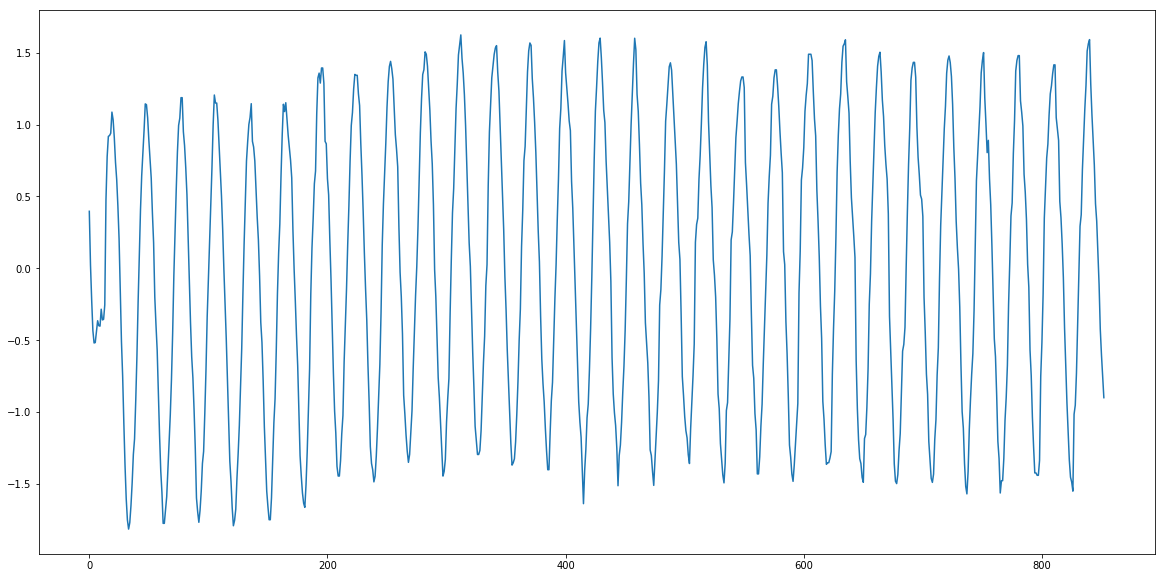

In [96]:
window = 1
edge = int(np.ceil(window/2))

def preprocess(data):
    # Calculate the moving average
    data = data.rolling(window=window,center=True).mean()
    # Trim the data that wasn't part of the moving average
    data = data[edge:-edge]
    # Standardize the data
    return preprocessing.scale(data) 

t = data["VideoAnalysis: Time (s)"][edge:-edge]
X_data = preprocess(data["VideoAnalysis: X"])
Y_data = preprocess(data["VideoAnalysis: Y"])

plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(Y_data)

In [104]:
def _load_data(data, n_prev = 120):
    """
    data should be pd.DataFrame()
    """
    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.2):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(df) * (1 - test_size)))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(pd.DataFrame(Y_data), 0.3)

In [113]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=False), input_shape=(None, 1)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=True)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")

In [114]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.1)

Train on 429 samples, validate on 48 samples
Epoch 1/100
429/429 [==============================] - 2s 4ms/step - loss: 0.4481 - val_loss: 0.3563
Epoch 2/100
429/429 [==============================] - 1s 1ms/step - loss: 0.3650 - val_loss: 0.2796
Epoch 3/100
429/429 [==============================] - 1s 1ms/step - loss: 0.2895 - val_loss: 0.2137
Epoch 4/100
429/429 [==============================] - 1s 1ms/step - loss: 0.2237 - val_loss: 0.1599
Epoch 5/100
429/429 [==============================] - 1s 1ms/step - loss: 0.1693 - val_loss: 0.1149
Epoch 6/100
429/429 [==============================] - 1s 1ms/step - loss: 0.1237 - val_loss: 0.0810
Epoch 7/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0887 - val_loss: 0.0563
Epoch 8/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0639 - val_loss: 0.0373
Epoch 9/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0457 - val_loss: 0.0260
Epoch 10/100
429/429 [========================

Epoch 81/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0128
Epoch 82/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0129
Epoch 83/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0127
Epoch 84/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0127
Epoch 85/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0128
Epoch 86/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0128
Epoch 87/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0130
Epoch 88/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0127
Epoch 89/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0095 - val_loss: 0.0126
Epoch 90/100
429/429 [==============================] - 1s 1ms/step - loss: 0.0094

In [115]:
# evaluate model fit
print(X_test.shape)
score = model.evaluate(X_test, y_test)
print('Test score:', score)

(136, 120, 1)
136/136 [==============================] - 0s 517us/step
Test score: 0.013540555777795175


In [116]:
# visualize predictions
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

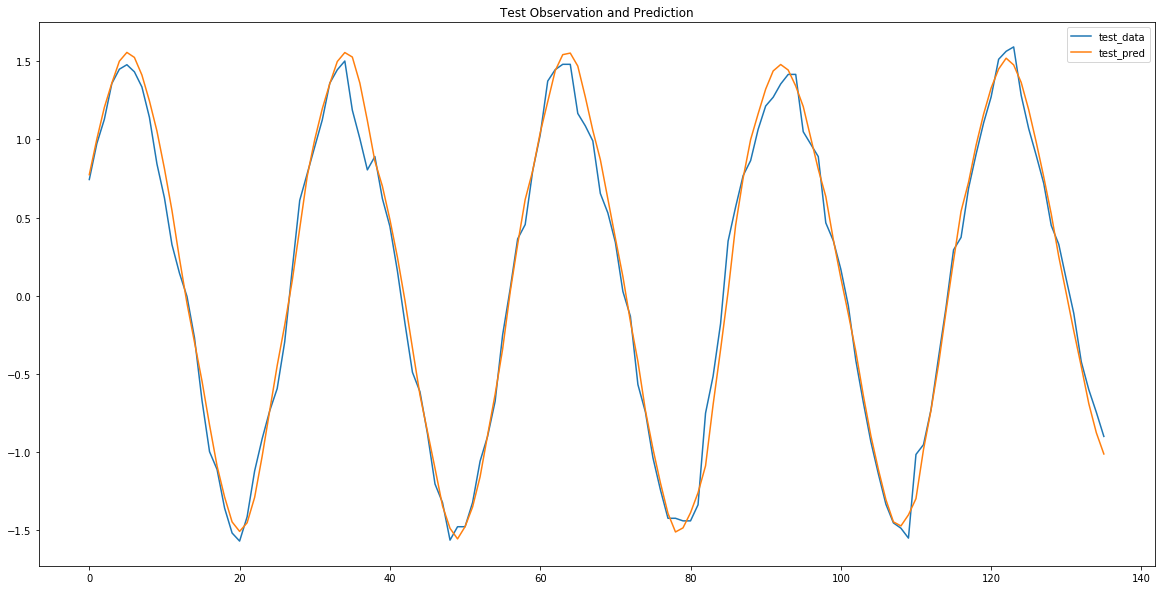

In [117]:
plt.figure(figsize=(20,10))
plt.plot(y_test[:], label='test_data')
plt.plot(test_prediction[:], label='test_pred')
plt.title('Test Observation and Prediction')
plt.legend()

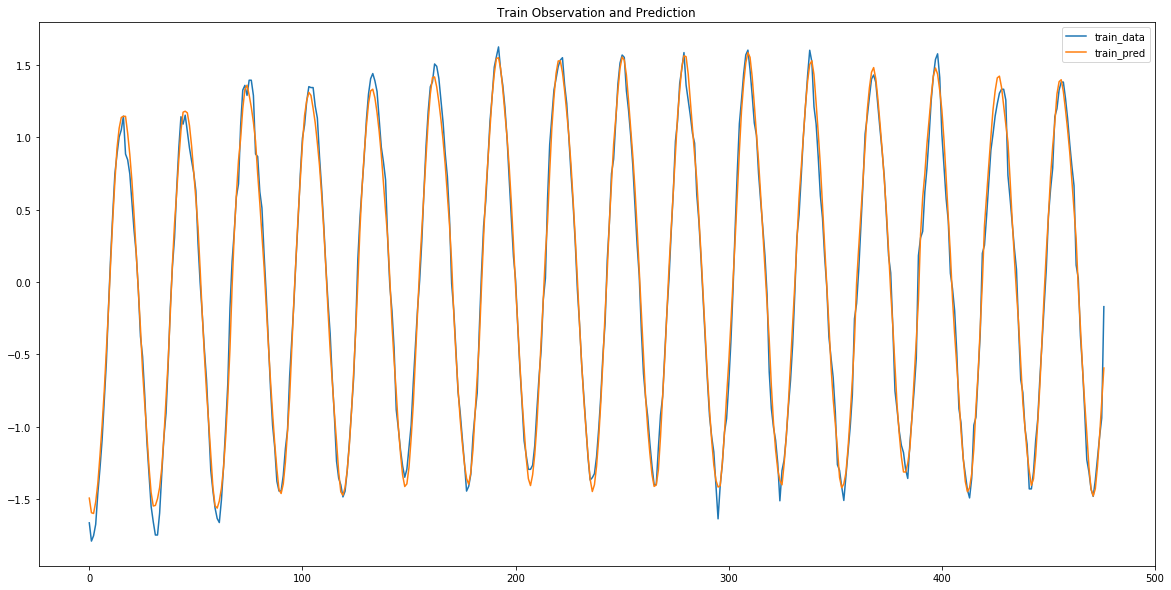

In [119]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()